<a href="https://colab.research.google.com/github/TWBanana/CS652/blob/master/Semi_Final/SemiFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [154]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [155]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import imageio

from numpy import pi
from numpy import sin
from numpy import zeros
from numpy import r_
from scipy import signal
from scipy import misc # pip install Pillow
import matplotlib.pylab as pylab

%matplotlib inline
pylab.rcParams['figure.figsize'] = (20.0, 7.0)

TiffPages: invalid page offset 2290452617
TiffPages: invalid page offset 219090958


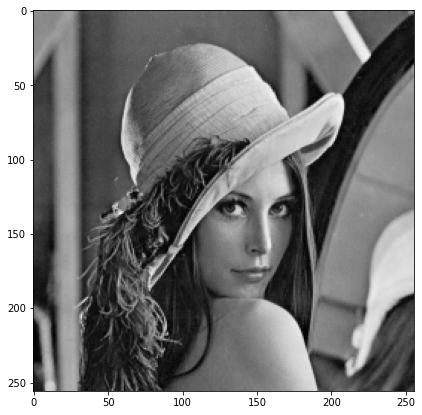

In [156]:
im = imageio.imread("/content/drive/MyDrive/NJIT/CS652/lena.tif").astype(float)
im2 = imageio.imread("/content/drive/MyDrive/zelda.tif").astype(float)

f = plt.figure()
plt.imshow(im,cmap='gray')

In [157]:
QUANTIZATION_MAT = np.array([
                             [16,11,10,16,24,40,51,61],
                             [12,12,14,19,26,58,60,55],
                             [14,13,16,24,40,57,69,56],
                             [14,17,22,29,51,87,80,62],
                             [18,22,37,56,68,109,103,77],
                             [24,35,55,64,81,104,113,92],
                             [49,64,78,87,103,121,120,101],
                             [72,92,95,98,112,100,103,99]
                            ])



Default Normalization Matrix in JPEG

In [158]:
def dct2(a):
  return scipy.fft.dct( scipy.fft.dct(a, axis=0, norm='ortho') , axis = 1, norm='ortho')

def idct2(a):
  return scipy.fft.idct( scipy.fft.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')

def storeCoefficients(matrix):
  arr = []
  for k in range(8):
    for l in range(8):
      arr.append(matrix[k, l])
  return arr

def quantize(matrix):
  QP=1
  QM = QUANTIZATION_MAT * QP
  return  np.floor((matrix + QM / 2) / (QM))


def calculate_MSE(input1, input2):
  return np.square(np.subtract(input1, input2).mean())


def VLC_coding(input):

  message = input
  message_list = []
  count = 1
  for i in range(0, len(message)):
    if i + 1 < len(message) and message[i] == message[i + 1]:
      count += 1
    else:
      message_list.append(message[i])
      message_list.append(count)
      count = 1

  buf = ""
  for index, value in enumerate(message_list):
    if index % 2 == 0:
      buf += "(" + str(value) + ", "
    else:
      buf += str(value) + ") "

  return buf
  

#  Zig zag scanning
def zigzag(input):
    #initializing the variables
    #----------------------------------
    h = 0
    v = 0
    vmin = 0
    hmin = 0
    vmax = input.shape[0]
    hmax = input.shape[1]
    i = 0

    output = np.zeros(( vmax * hmax))
    #----------------------------------

    while ((v < vmax) and (h < hmax)):
        if ((h + v) % 2) == 0:                 
            if (v == vmin):
                output[i] = input[v, h]        
                if (h == hmax):
                    v = v + 1
                else:
                    h = h + 1                        
                i = i + 1
            elif ((h == hmax -1 ) and (v < vmax)):   
            	output[i] = input[v, h] 
            	v = v + 1
            	i = i + 1
            elif ((v > vmin) and (h < hmax -1 )):    
            	output[i] = input[v, h] 
            	v = v - 1
            	h = h + 1
            	i = i + 1

        else:                                    
        	if ((v == vmax -1) and (h <= hmax -1)):       
        		output[i] = input[v, h] 
        		h = h + 1
        		i = i + 1
        	elif (h == hmin):                  
        		output[i] = input[v, h] 
        		if (v == vmax -1):
        			h = h + 1
        		else:
        			v = v + 1
        		i = i + 1
        	elif ((v < vmax -1) and (h > hmin)):     
        		output[i] = input[v, h] 
        		v = v + 1
        		h = h - 1
        		i = i + 1
        if ((v == vmax-1) and (h == hmax-1)):          
        	output[i] = input[v, h] 
        	break

    return output


Text(0.5, 1.0, 'After compression')

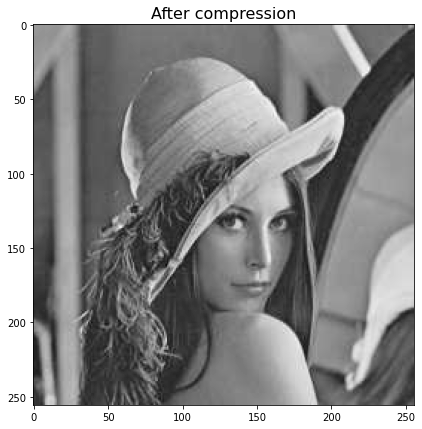

In [160]:
imsize = im.shape
dct = np.zeros(imsize)      # create empty array for storing the data after applying DCT
qdct = np.zeros(imsize)     # create empty array for storing the data after applying inverse DCT
after = np.zeros(imsize)
array = []
imarray = []
qarray = []

for i in r_[:imsize[0]:8]:
  for j in r_[:imsize[1]:8]:     # loop through every 8*8 block
    dct[i:(i+8), j:(j+8)] = dct2(im[i:(i+8), j:(j+8)])  # dct transform
    matrix = dct[i:(i+8), j:(j+8)]  
    arr = storeCoefficients(matrix)

    qdct[i:(i+8), j:(j+8)] = quantize(matrix)   # quantization
    qmatrix = qdct[i:(i+8), j:(j+8)]
    qmatrix = idct2(qmatrix * QUANTIZATION_MAT) # decode
    qarr = storeCoefficients(qmatrix)

    after[i:(i+8), j:(j+8)] = qmatrix
    
    array.append(arr)
    qarray.append(qarr)                      
    imarray.append(storeCoefficients(im[i:(i+8), j:(j+8)]))
    

plt.figure()
plt.imshow(after, cmap="gray")
plt.title("After compression", fontsize=16)


In [180]:
# new_array = []
new_qarray = []
new_imarray = []

for i in range(len(array[0])):
  # arr = []
  qarr = []
  imarr = []
  for j in range(len(array)):
    # arr.append(array[j][i])
    qarr.append(qarray[j][i]) 
    imarr.append(imarray[j][i])

  # new_array.append(arr)
  new_qarray.append(qarr)
  new_imarray.append(imarr)



In [181]:
D = []
for i in range(len(new_imarray)):
  D.append(calculate_MSE(new_imarray[i], new_qarray[i]))

print("Distortion:", D[:5], "...")

Distortion: [0.009750934746013507, 0.010092736374891042, 0.026873406678197986, 0.0006281801231205538, 0.08594814605357516] ...


Calculate MSE (D)

In [182]:
var_array = []

for i in range(64):
  temp = [0 for _ in range(64)]
  for j in range(64):
    temp[j] = array[j][i]
  variance = np.var(temp)
  var_array.append(variance)

print("Variance:", var_array[:5], "...")

Variance: [47563.134304046645, 6180.658074110279, 528.4539614979267, 119.05588991752195, 39.16238021850596] ...


Calculate the variance for all 64 coefficient.

In [183]:
RD_list = []
for i in range(len(var_array)):
  RD = (1/2) * np.log(var_array[i] / D[i])
  RD_list.append(RD)

print("Distortion:", D[:5], "...\n\nR(D):", RD_list[:5], "...")

Distortion: [0.009750934746013507, 0.010092736374891042, 0.026873406678197986, 0.0006281801231205538, 0.08594814605357516] ...

R(D): [7.700102688959303, 6.662559656965848, 4.943286885279837, 6.0761383291961195, 3.060863857570278] ...


1. **maxD:** maximum average distortion D 
2. RD: $(1/2) * log(\sigma^2/maxD)$

Text(0, 0.5, 'Rate-Distrotion')

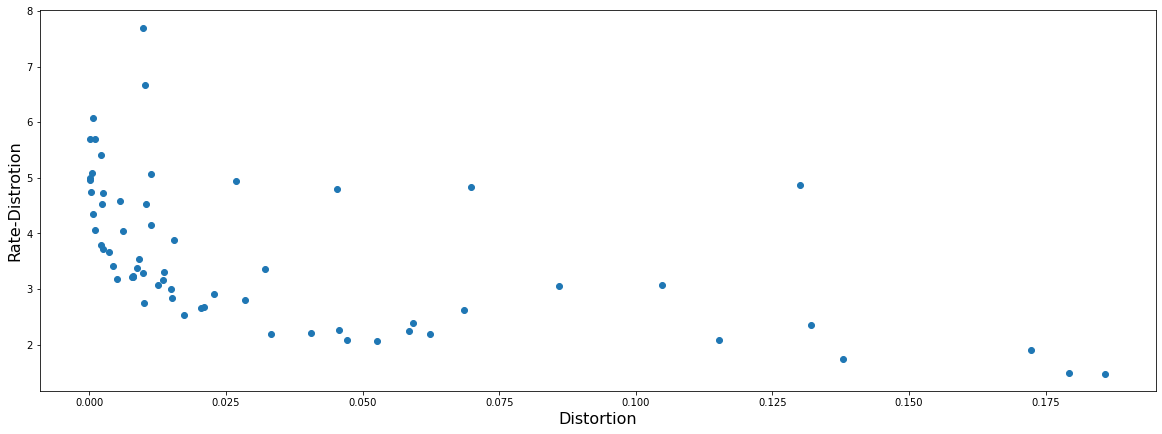

In [205]:
plt.scatter(D, RD_list)
plt.xlabel("Distortion", fontsize=16)
plt.ylabel("Rate-Distrotion", fontsize=16)

In [185]:
mat = np.zeros((8,8))
index = 0
for i in range(8):
  for j in range(8):
    mat[i][j] = var_array[index]
    index += 1

Create new matrix to store the all vaiances

Using zig-zag scanning to scan the variance.

(array([-10000.,      0.,  10000.,  20000.,  30000.,  40000.,  50000.]),
 <a list of 7 Text major ticklabel objects>)

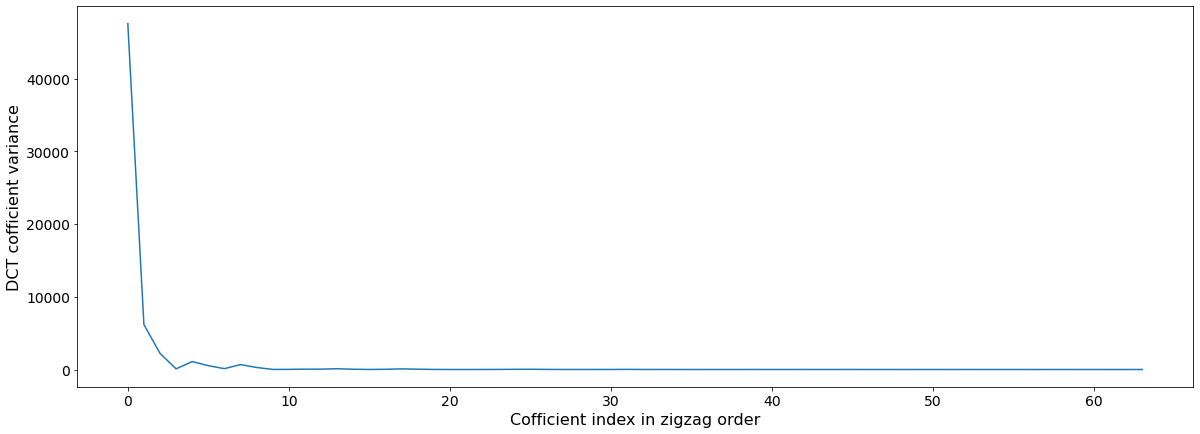

In [186]:
final = zigzag(mat)
plt.plot(final)
plt.xlabel('Cofficient index in zigzag order', fontsize=16)
plt.ylabel('DCT cofficient variance', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [187]:
var_max = max(var_array)
var_max

47563.134304046645

Maximum variance : $\sigma^2_{max}$

In [188]:
dct_block = dct[0:8, 0:8]
quan_dct = quantize(dct_block)
zz_dct = zigzag(quan_dct)
print(quan_dct, "\n\n\n", VLC_coding(zz_dct))

[[66.  1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]] 


 (66.0, 1) (1.0, 2) (0.0, 61) 


Example:

Extract one block (8*8)

Apply VLC coding

